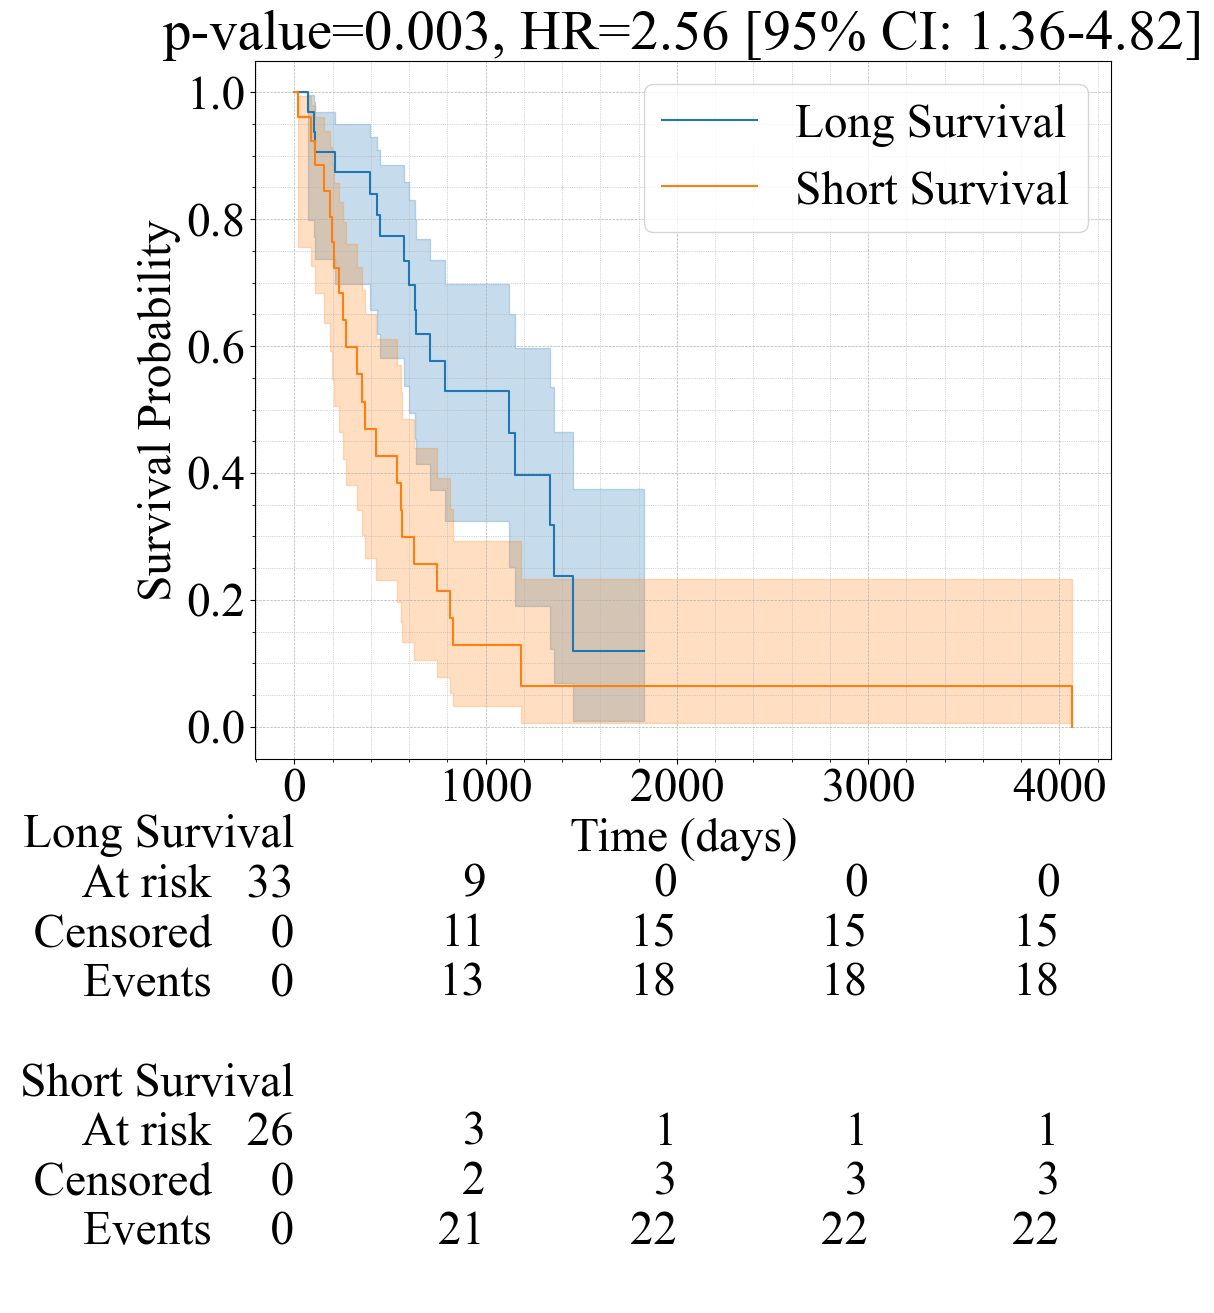

In [5]:
#RF
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Function to load data
def load_data():
    train_data = pd.read_csv('D:/radiomic clinic/new_updated_train_dataset _add.csv')
    test_data = pd.read_csv('D:/radiomic clinic/new_updated_test_dataset.csv')
    return train_data, test_data

# Function to prepare data
def prepare_data(train_data, test_data):
    X_train = train_data.drop(columns=['OS.time', 'OS', 'index'])
    y_train = train_data['OS']
    X_test = test_data.drop(columns=['OS.time', 'OS', 'index'])
    return X_train, y_train, X_test

# Function to train Random Forest classifier
def train_classifier(X_train, y_train):
    model = RandomForestClassifier(n_estimators=300, random_state=42)
    model.fit(X_train, y_train)
    return model

# Function to predict and assign survival groups
def assign_survival_groups(model, train_data, test_data):
    # Combine train and test data
    combined_data = pd.concat([train_data, test_data], axis=0)
    X_combined = combined_data.drop(columns=['OS.time', 'OS', 'index'])
    
    # Predict probabilities using the trained model
    probabilities = model.predict_proba(X_combined)[:, 1]
    
    # Calculate median probability
    median_prob = np.median(probabilities)
    
    # Assign survival groups based on the calculated median probability
    combined_data['Survival_Group'] = ['Short Survival' if p >= median_prob else 'Long Survival' for p in probabilities]
    
    # Split the combined data back into train and test data
    train_data['Survival_Group'] = combined_data.iloc[:len(train_data)]['Survival_Group']
    test_data['Survival_Group'] = combined_data.iloc[len(train_data):]['Survival_Group']
    
    return train_data, test_data

# Function to perform Kaplan-Meier analysis and plot results
def perform_km_analysis(test_data):
    plt.rcParams["font.family"] = "Times New Roman"  # Set font to Times New Roman
    plt.rcParams["font.size"] = 34  # Increase font size

    kmf_long = KaplanMeierFitter()
    kmf_short = KaplanMeierFitter()
    long_survival_data = test_data[test_data['Survival_Group'] == 'Long Survival']
    short_survival_data = test_data[test_data['Survival_Group'] == 'Short Survival']
    T_long, E_long = long_survival_data['OS.time'], long_survival_data['OS']
    T_short, E_short = short_survival_data['OS.time'], short_survival_data['OS']

    # Fit Cox Proportional Hazards model
    df = pd.DataFrame({
        'time': np.concatenate([T_long, T_short]),
        'event': np.concatenate([E_long, E_short]),
        'group': ['Long'] * len(T_long) + ['Short'] * len(T_short)
    })
    cph = CoxPHFitter()
    cph.fit(df, 'time', event_col='event', formula='group')
    hr = cph.summary.loc['group[T.Short]', 'exp(coef)']
    ci_lower = cph.summary.loc['group[T.Short]', 'exp(coef) lower 95%']
    ci_upper = cph.summary.loc['group[T.Short]', 'exp(coef) upper 95%']

    fig, ax = plt.subplots(figsize=(12,10))  # Increase figure size
    kmf_long.fit(T_long, E_long, label='Long Survival').plot(ax=ax)
    kmf_short.fit(T_short, E_short, label='Short Survival').plot(ax=ax)
    
    ax.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal grid lines
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth=0.5)  # Add minor grid lines

    add_at_risk_counts(kmf_long, kmf_short, ax=ax, labels=['Long Survival', 'Short Survival'], ypos=-0.5)  # Move risk table down
    
    results = logrank_test(T_long, T_short, event_observed_A=E_long, event_observed_B=E_short)
    
    plt.title(f'p-value={results.p_value:.3f}, HR={hr:.2f} [95% CI: {ci_lower:.2f}-{ci_upper:.2f}]')
    ax.set_ylabel('Survival Probability')  # Ensure Y-axis label is set
    ax.set_xlabel('Time (days)')  # Hide the X-axis label by setting it to an empty string
    plt.tight_layout()  # Adjust layout to make room for the risk table
    plt.subplots_adjust(bottom=0.2)  # Adjust the space at the bottom for the X-axis label
    plt.show()
    return results

# Main execution
try:
    train_data, test_data = load_data()
    X_train, y_train, X_test = prepare_data(train_data, test_data)
    model = train_classifier(X_train, y_train)
    train_data, test_data = assign_survival_groups(model, train_data, test_data)
    results = perform_km_analysis(test_data)
except Exception as e:
    print(f"An error occurred: {e}")


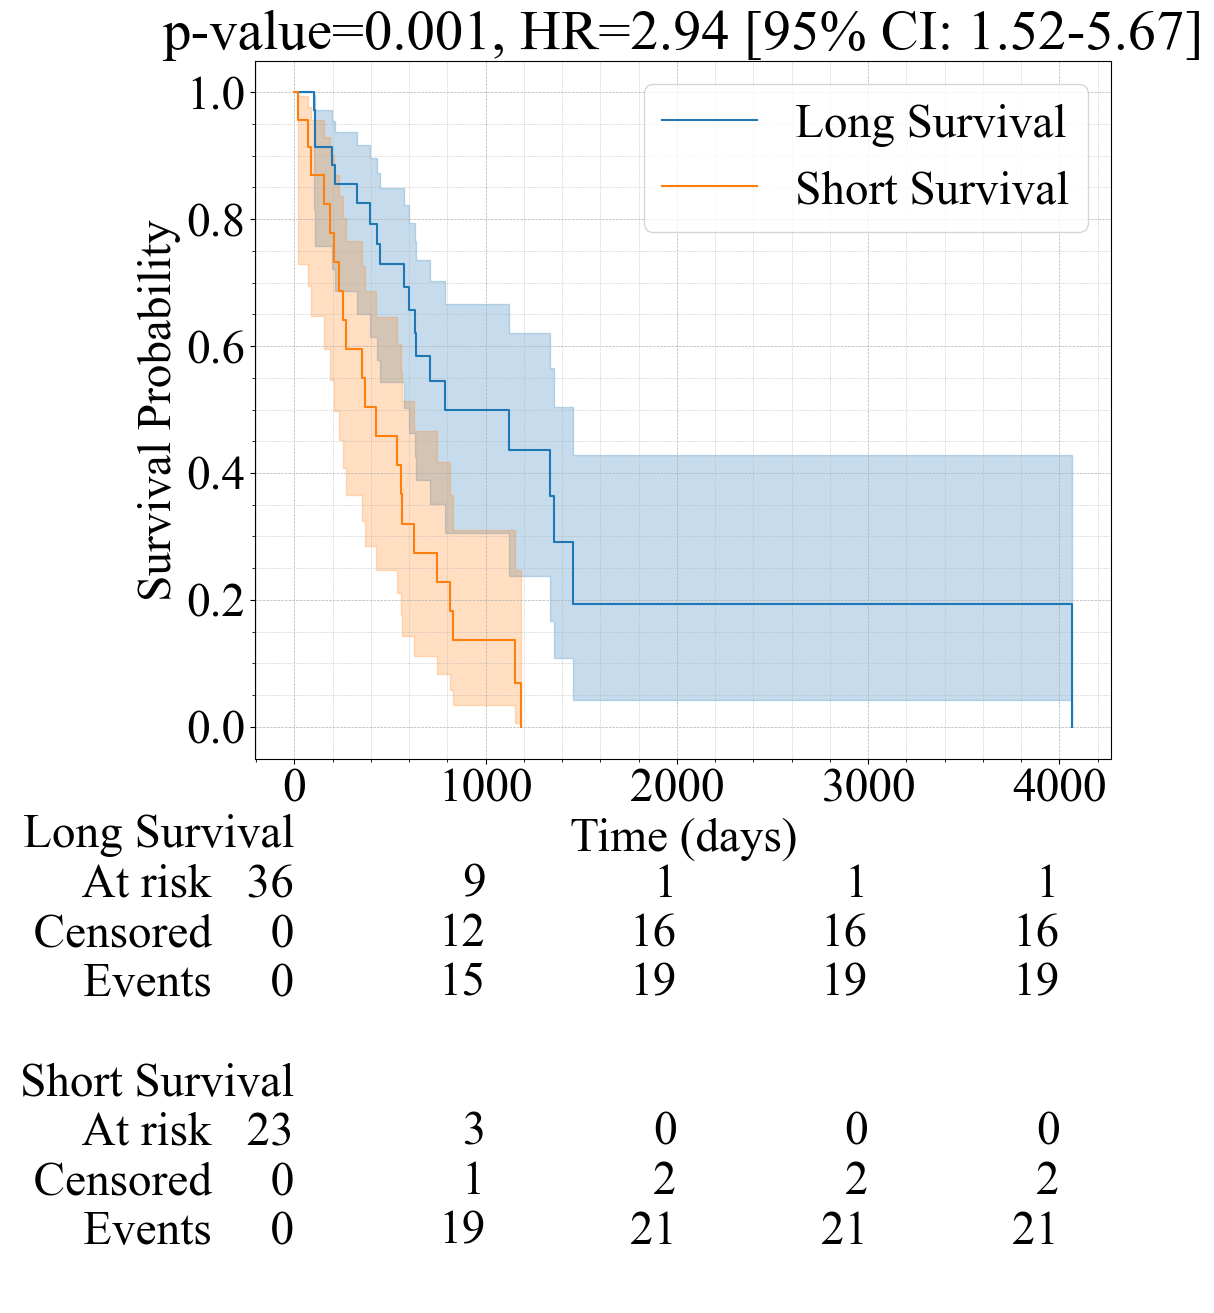

In [6]:
#XGBOOST
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Function to load data
def load_data():
    train_data = pd.read_csv('D:/radiomic clinic/new_updated_train_dataset _add.csv')
    test_data = pd.read_csv('D:/radiomic clinic/new_updated_test_dataset.csv')
    return train_data, test_data

# Function to prepare data
def prepare_data(train_data, test_data):
    X_train = train_data.drop(columns=['OS.time', 'OS', 'index'])
    y_train = train_data['OS']
    X_test = test_data.drop(columns=['OS.time', 'OS', 'index'])
    return X_train, y_train, X_test

# Function to train Random Forest classifier
def train_classifier(X_train, y_train):
    model = XGBClassifier(use_label_encoder=False)
    model.fit(X_train, y_train)
    return model

# Function to predict and assign survival groups
def assign_survival_groups(model, train_data, test_data):
    # Combine train and test data
    combined_data = pd.concat([train_data, test_data], axis=0)
    X_combined = combined_data.drop(columns=['OS.time', 'OS', 'index'])
    
    # Predict probabilities using the trained model
    probabilities = model.predict_proba(X_combined)[:, 1]
    
    # Calculate median probability
    median_prob = np.median(probabilities)
    
    # Assign survival groups based on the calculated median probability
    combined_data['Survival_Group'] = ['Short Survival' if p >= median_prob else 'Long Survival' for p in probabilities]
    
    # Split the combined data back into train and test data
    train_data['Survival_Group'] = combined_data.iloc[:len(train_data)]['Survival_Group']
    test_data['Survival_Group'] = combined_data.iloc[len(train_data):]['Survival_Group']
    
    return train_data, test_data

# Function to perform Kaplan-Meier analysis and plot results
def perform_km_analysis(test_data):
    plt.rcParams["font.family"] = "Times New Roman"  # Set font to Times New Roman
    plt.rcParams["font.size"] = 34  # Increase font size

    kmf_long = KaplanMeierFitter()
    kmf_short = KaplanMeierFitter()
    long_survival_data = test_data[test_data['Survival_Group'] == 'Long Survival']
    short_survival_data = test_data[test_data['Survival_Group'] == 'Short Survival']
    T_long, E_long = long_survival_data['OS.time'], long_survival_data['OS']
    T_short, E_short = short_survival_data['OS.time'], short_survival_data['OS']

    # Fit Cox Proportional Hazards model
    df = pd.DataFrame({
        'time': np.concatenate([T_long, T_short]),
        'event': np.concatenate([E_long, E_short]),
        'group': ['Long'] * len(T_long) + ['Short'] * len(T_short)
    })
    cph = CoxPHFitter()
    cph.fit(df, 'time', event_col='event', formula='group')
    hr = cph.summary.loc['group[T.Short]', 'exp(coef)']
    ci_lower = cph.summary.loc['group[T.Short]', 'exp(coef) lower 95%']
    ci_upper = cph.summary.loc['group[T.Short]', 'exp(coef) upper 95%']

    fig, ax = plt.subplots(figsize=(12,10))  # Increase figure size
    kmf_long.fit(T_long, E_long, label='Long Survival').plot(ax=ax)
    kmf_short.fit(T_short, E_short, label='Short Survival').plot(ax=ax)
    
    ax.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal grid lines
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth=0.5)  # Add minor grid lines

    add_at_risk_counts(kmf_long, kmf_short, ax=ax, labels=['Long Survival', 'Short Survival'], ypos=-0.5)  # Move risk table down
    
    results = logrank_test(T_long, T_short, event_observed_A=E_long, event_observed_B=E_short)
    
    plt.title(f'p-value={results.p_value:.3f}, HR={hr:.2f} [95% CI: {ci_lower:.2f}-{ci_upper:.2f}]')
    ax.set_ylabel('Survival Probability')  # Ensure Y-axis label is set
    ax.set_xlabel('Time (days)')  # Hide the X-axis label by setting it to an empty string
    plt.tight_layout()  # Adjust layout to make room for the risk table
    plt.subplots_adjust(bottom=0.2)  # Adjust the space at the bottom for the X-axis label
    plt.show()
    return results

# Main execution
try:
    train_data, test_data = load_data()
    X_train, y_train, X_test = prepare_data(train_data, test_data)
    model = train_classifier(X_train, y_train)
    train_data, test_data = assign_survival_groups(model, train_data, test_data)
    results = perform_km_analysis(test_data)
except Exception as e:
    print(f"An error occurred: {e}")


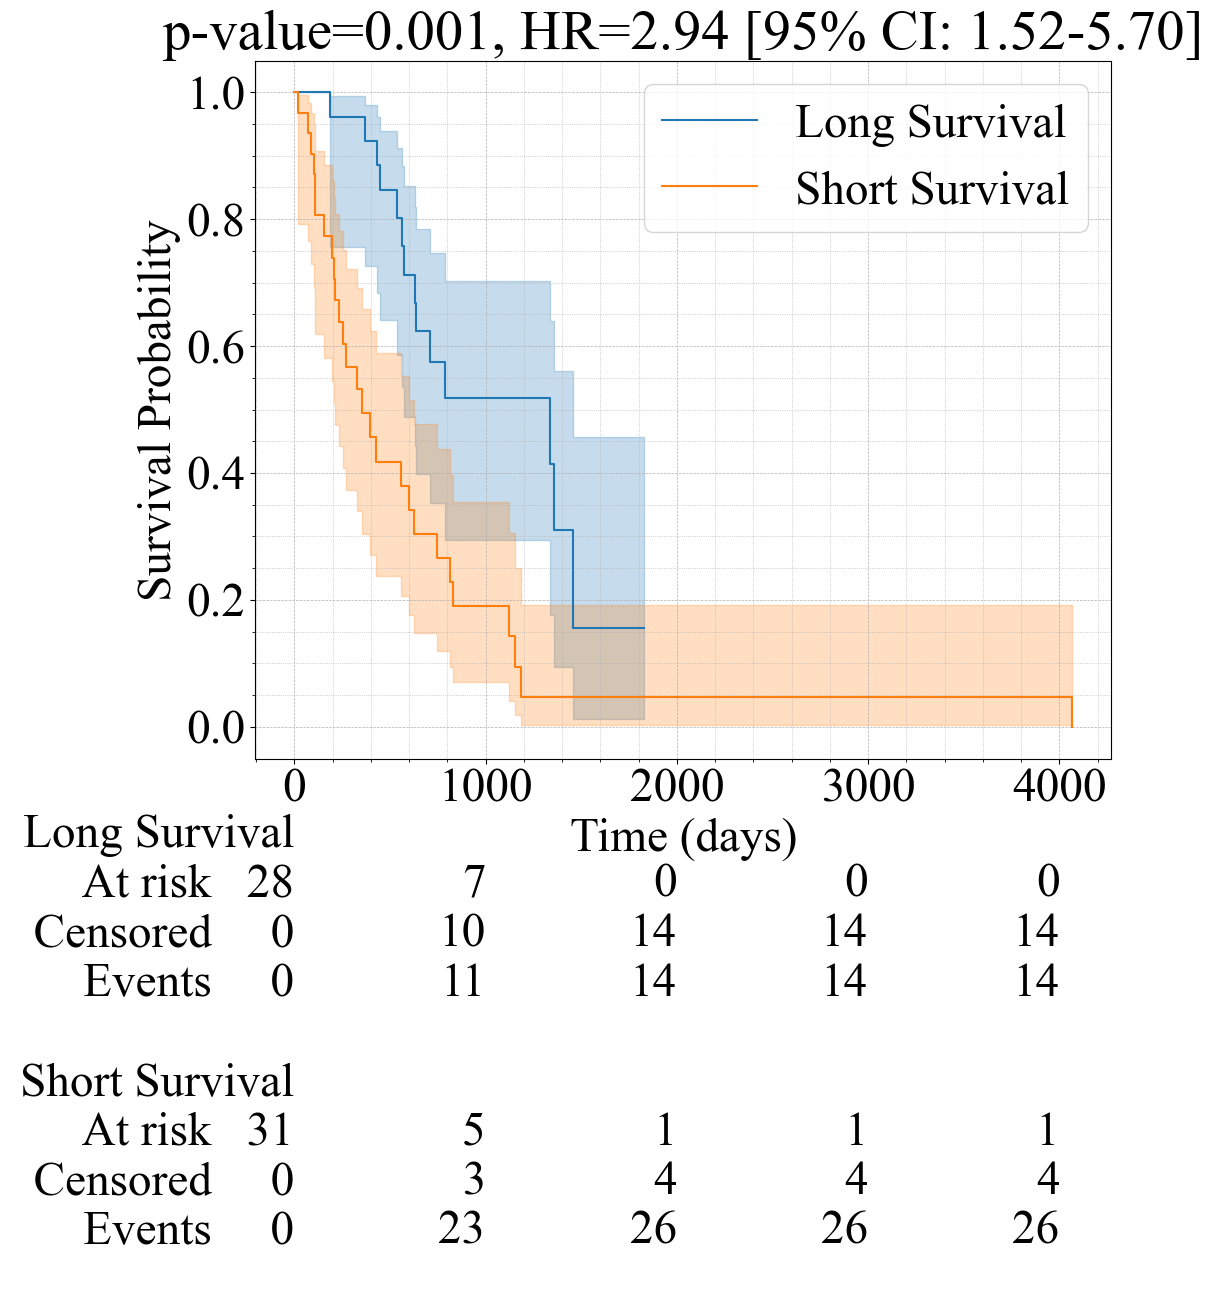

In [7]:
#LR
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Function to load data
def load_data():
    train_data = pd.read_csv('D:/radiomic clinic/new_updated_train_dataset _add.csv')
    test_data = pd.read_csv('D:/radiomic clinic/new_updated_test_dataset.csv')
    return train_data, test_data

# Function to prepare data
def prepare_data(train_data, test_data):
    X_train = train_data.drop(columns=['OS.time', 'OS', 'index'])
    y_train = train_data['OS']
    X_test = test_data.drop(columns=['OS.time', 'OS', 'index'])
    return X_train, y_train, X_test

# Function to train Random Forest classifier
def train_classifier(X_train, y_train):
    model = LogisticRegression(penalty="l2", solver="liblinear", C=1.0, max_iter=100)
    model.fit(X_train, y_train)
    return model

# Function to predict and assign survival groups
def assign_survival_groups(model, train_data, test_data):
    # Combine train and test data
    combined_data = pd.concat([train_data, test_data], axis=0)
    X_combined = combined_data.drop(columns=['OS.time', 'OS', 'index'])
    
    # Predict probabilities using the trained model
    probabilities = model.predict_proba(X_combined)[:, 1]
    
    # Calculate median probability
    median_prob = np.median(probabilities)
    
    # Assign survival groups based on the calculated median probability
    combined_data['Survival_Group'] = ['Short Survival' if p >= median_prob else 'Long Survival' for p in probabilities]
    
    # Split the combined data back into train and test data
    train_data['Survival_Group'] = combined_data.iloc[:len(train_data)]['Survival_Group']
    test_data['Survival_Group'] = combined_data.iloc[len(train_data):]['Survival_Group']
    
    return train_data, test_data

# Function to perform Kaplan-Meier analysis and plot results
def perform_km_analysis(test_data):
    plt.rcParams["font.family"] = "Times New Roman"  # Set font to Times New Roman
    plt.rcParams["font.size"] = 34  # Increase font size

    kmf_long = KaplanMeierFitter()
    kmf_short = KaplanMeierFitter()
    long_survival_data = test_data[test_data['Survival_Group'] == 'Long Survival']
    short_survival_data = test_data[test_data['Survival_Group'] == 'Short Survival']
    T_long, E_long = long_survival_data['OS.time'], long_survival_data['OS']
    T_short, E_short = short_survival_data['OS.time'], short_survival_data['OS']

    # Fit Cox Proportional Hazards model
    df = pd.DataFrame({
        'time': np.concatenate([T_long, T_short]),
        'event': np.concatenate([E_long, E_short]),
        'group': ['Long'] * len(T_long) + ['Short'] * len(T_short)
    })
    cph = CoxPHFitter()
    cph.fit(df, 'time', event_col='event', formula='group')
    hr = cph.summary.loc['group[T.Short]', 'exp(coef)']
    ci_lower = cph.summary.loc['group[T.Short]', 'exp(coef) lower 95%']
    ci_upper = cph.summary.loc['group[T.Short]', 'exp(coef) upper 95%']

    fig, ax = plt.subplots(figsize=(12,10))  # Increase figure size
    kmf_long.fit(T_long, E_long, label='Long Survival').plot(ax=ax)
    kmf_short.fit(T_short, E_short, label='Short Survival').plot(ax=ax)
    
    ax.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal grid lines
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth=0.5)  # Add minor grid lines

    add_at_risk_counts(kmf_long, kmf_short, ax=ax, labels=['Long Survival', 'Short Survival'], ypos=-0.5)  # Move risk table down
    
    results = logrank_test(T_long, T_short, event_observed_A=E_long, event_observed_B=E_short)
    
    plt.title(f'p-value={results.p_value:.3f}, HR={hr:.2f} [95% CI: {ci_lower:.2f}-{ci_upper:.2f}]')
    ax.set_ylabel('Survival Probability')  # Ensure Y-axis label is set
    ax.set_xlabel('Time (days)')  # Hide the X-axis label by setting it to an empty string
    plt.tight_layout()  # Adjust layout to make room for the risk table
    plt.subplots_adjust(bottom=0.2)  # Adjust the space at the bottom for the X-axis label
    plt.show()
    return results

# Main execution
try:
    train_data, test_data = load_data()
    X_train, y_train, X_test = prepare_data(train_data, test_data)
    model = train_classifier(X_train, y_train)
    train_data, test_data = assign_survival_groups(model, train_data, test_data)
    results = perform_km_analysis(test_data)
except Exception as e:
    print(f"An error occurred: {e}")


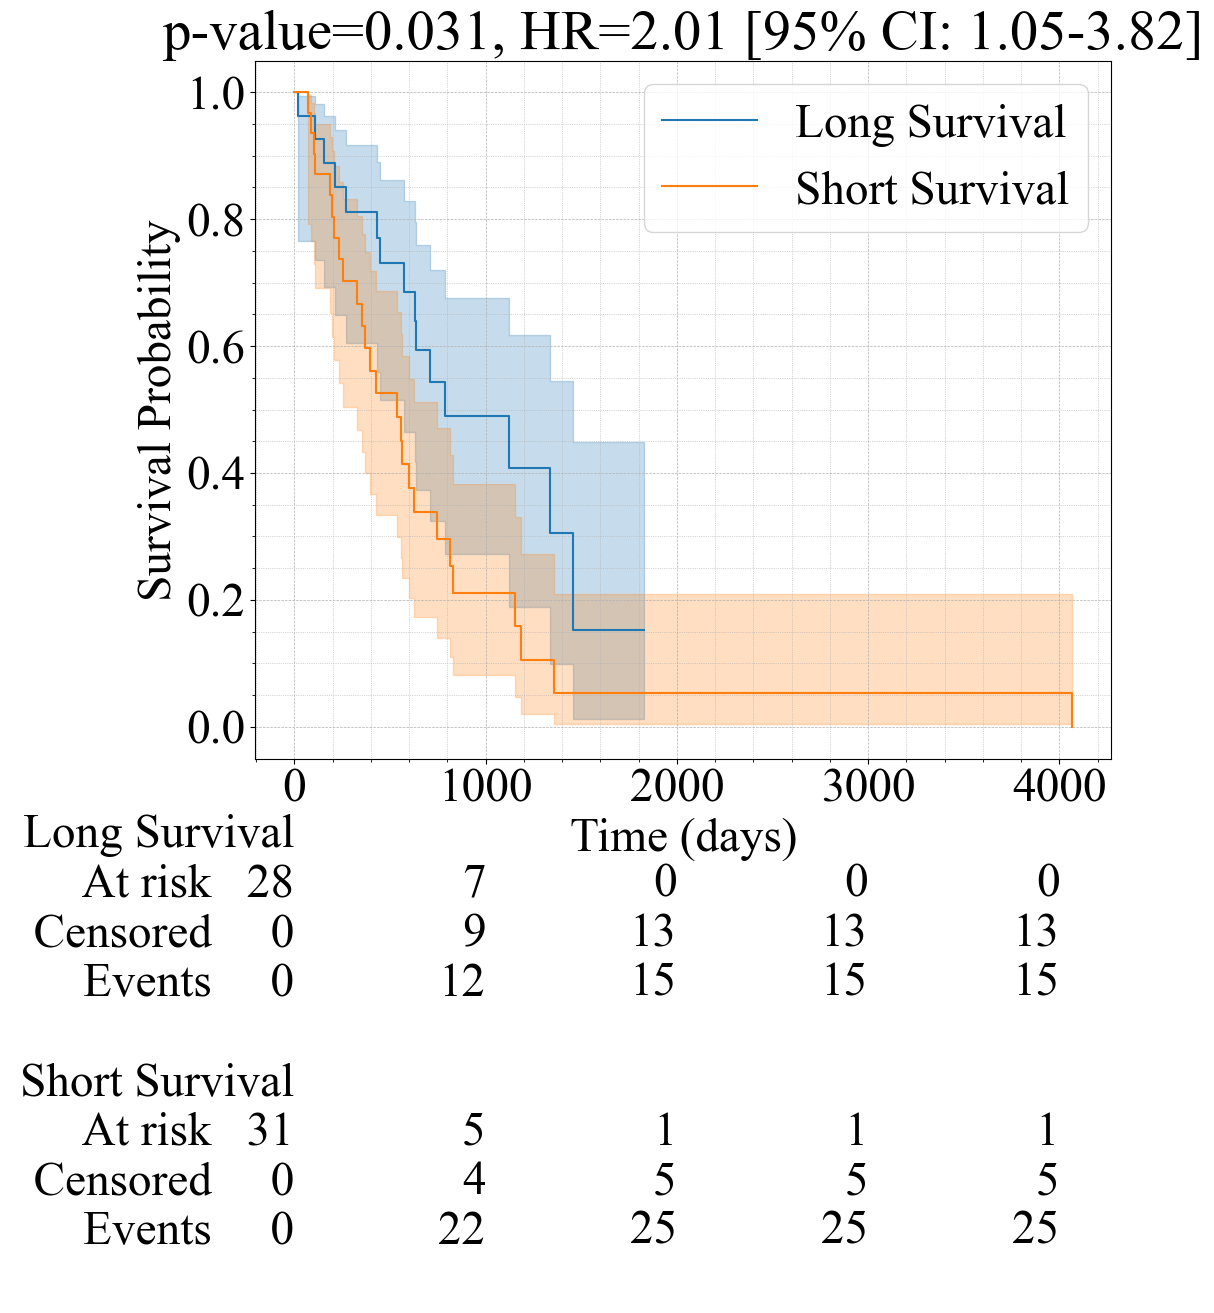

In [8]:
#SVM

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Function to load data
def load_data():
    train_data = pd.read_csv('D:/radiomic clinic/new_updated_train_dataset _add.csv')
    test_data = pd.read_csv('D:/radiomic clinic/new_updated_test_dataset.csv')
    return train_data, test_data

# Function to prepare data
def prepare_data(train_data, test_data):
    X_train = train_data.drop(columns=['OS.time', 'OS', 'index'])
    y_train = train_data['OS']
    X_test = test_data.drop(columns=['OS.time', 'OS', 'index'])
    return X_train, y_train, X_test

# Function to train Random Forest classifier
def train_classifier(X_train, y_train):
    model = SVC(kernel='rbf', C=1.0, probability=True)
    model.fit(X_train, y_train)
    return model

# Function to predict and assign survival groups
def assign_survival_groups(model, train_data, test_data):
    # Combine train and test data
    combined_data = pd.concat([train_data, test_data], axis=0)
    X_combined = combined_data.drop(columns=['OS.time', 'OS', 'index'])
    
    # Predict probabilities using the trained model
    probabilities = model.predict_proba(X_combined)[:, 1]
    
    # Calculate median probability
    median_prob = np.median(probabilities)
    
    # Assign survival groups based on the calculated median probability
    combined_data['Survival_Group'] = ['Short Survival' if p >= median_prob else 'Long Survival' for p in probabilities]
    
    # Split the combined data back into train and test data
    train_data['Survival_Group'] = combined_data.iloc[:len(train_data)]['Survival_Group']
    test_data['Survival_Group'] = combined_data.iloc[len(train_data):]['Survival_Group']
    
    return train_data, test_data

# Function to perform Kaplan-Meier analysis and plot results
def perform_km_analysis(test_data):
    plt.rcParams["font.family"] = "Times New Roman"  # Set font to Times New Roman
    plt.rcParams["font.size"] = 34  # Increase font size

    kmf_long = KaplanMeierFitter()
    kmf_short = KaplanMeierFitter()
    long_survival_data = test_data[test_data['Survival_Group'] == 'Long Survival']
    short_survival_data = test_data[test_data['Survival_Group'] == 'Short Survival']
    T_long, E_long = long_survival_data['OS.time'], long_survival_data['OS']
    T_short, E_short = short_survival_data['OS.time'], short_survival_data['OS']

    # Fit Cox Proportional Hazards model
    df = pd.DataFrame({
        'time': np.concatenate([T_long, T_short]),
        'event': np.concatenate([E_long, E_short]),
        'group': ['Long'] * len(T_long) + ['Short'] * len(T_short)
    })
    cph = CoxPHFitter()
    cph.fit(df, 'time', event_col='event', formula='group')
    hr = cph.summary.loc['group[T.Short]', 'exp(coef)']
    ci_lower = cph.summary.loc['group[T.Short]', 'exp(coef) lower 95%']
    ci_upper = cph.summary.loc['group[T.Short]', 'exp(coef) upper 95%']

    fig, ax = plt.subplots(figsize=(12,10))  # Increase figure size
    kmf_long.fit(T_long, E_long, label='Long Survival').plot(ax=ax)
    kmf_short.fit(T_short, E_short, label='Short Survival').plot(ax=ax)
    
    ax.grid(True, linestyle='--', linewidth=0.5)  # Add horizontal grid lines
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth=0.5)  # Add minor grid lines

    add_at_risk_counts(kmf_long, kmf_short, ax=ax, labels=['Long Survival', 'Short Survival'], ypos=-0.5)  # Move risk table down
    
    results = logrank_test(T_long, T_short, event_observed_A=E_long, event_observed_B=E_short)
    
    plt.title(f'p-value={results.p_value:.3f}, HR={hr:.2f} [95% CI: {ci_lower:.2f}-{ci_upper:.2f}]')
    ax.set_ylabel('Survival Probability')  # Ensure Y-axis label is set
    ax.set_xlabel('Time (days)')  # Hide the X-axis label by setting it to an empty string
    plt.tight_layout()  # Adjust layout to make room for the risk table
    plt.subplots_adjust(bottom=0.2)  # Adjust the space at the bottom for the X-axis label
    plt.show()
    return results

# Main execution
try:
    train_data, test_data = load_data()
    X_train, y_train, X_test = prepare_data(train_data, test_data)
    model = train_classifier(X_train, y_train)
    train_data, test_data = assign_survival_groups(model, train_data, test_data)
    results = perform_km_analysis(test_data)
except Exception as e:
    print(f"An error occurred: {e}")
